When trying to find the variance of the auto-normalize IMPS (AN-IMPS) estimator, I found out that AN-IMPS differs very much from the original IMPS. This notebook will try to gain a better understanding of those differences. We will try to implement the following: 
Given only a log density $f$ ( the density of the law that is hard to sample from (typically the posterior of the PLN model), and a function $\phi$, we will try to find : 

$$\mathbb E_f [\phi(X)]$$

Since we want to do so for particular functions $\phi$, we will show comparisons when taking those functions, that are ( for $W\in \mathbb R^q$): 

$$\begin{align}
\phi_1(W) & = \exp(CW) \in \mathbb R^p \\
\phi_2(W) & = \exp(CW)W^{\top} \in \mathbb R^{p \times q} \\
\phi_3(W) & = W \in \mathbb R^q 
\end{align}
$$

Since those integrals are multi dimensional (let say the dimension is $d$ for instance) , this problem is equivalent to evaluate $d$ integrals when the integrand takes an argument in $\mathbb R ^q$. We won't evaluate each coordinate of the integral, but only one coordinate as example for the whole vector.
Moreover, we will compare our result with numerical integration from scipy when $ q$ is small enough ( $\leq 2$). 
We will use gaussian as sampler for the importance law. Finding which mean and which variance to take is the more important parameter. We will take as mean the mode of $T_{i, \phi} :  W \mapsto |\phi(W)|f_i(W)$. For the variance, we will take the inverse of (minus) the hessian of this function (evaluate in the mode). Let's find the hessian of the posterior first. 

First, note that the formula of the unnormalized density is the following : 

$p^{(u)}_{\theta}(W_i) = \exp \left(-\frac{1}{2}\left\|W_{i}\right\|^{2}-\mathbb 1_{p}^{T} \exp \left(0_{i}+\beta ^{\top} X_{i}+ CW_{i}\right)+Y_{i}^{\top} CW_{i}\right)$

Taking the log and derving two times with respect to $W_i$ gives : 

$$ H_{\text{posterior}}(W) = - I_q- \sum _j ^p  C_j^{\top} C_j \exp(O_{ij} + \beta_j ^{\top} X_i + C_j W)$$

So that : 

$$ H_{T_i, \phi_1} (W_i) = H_{\text{posterior}}(W)$$

$$ H_{T_i, \phi_2} (W_i) = H_{\text{posterior}}(W) + \text{sign}(W_l)\frac 1 {W_l^2}$$

$$ H_{T_i, \phi_3} (W_i) = H_{T_i, \phi_2} (W_i)$$

(the letter $l$ represent the coordinate of the integral we are trying to compute)

So that, if $M_{i,\phi_k}$ is the mode of $T_{i, \phi_k}$, the importance law will be the following : 

$$\mathcal N ( M_{i, \phi_k}, \left ( -H_{T_i, \phi_k} (M_{i, \phi_k})\right ) ^{-1}) $$



In [78]:
import torch
import numpy as np
import matplotlib.pyplot as plt 
import scipy.linalg as SLA
import math
import seaborn as sns
import warnings
from scipy.linalg import toeplitz
from utils import sample_PLN, log_stirling
warnings.filterwarnings("ignore")
torch.set_default_dtype(torch.float64)
import scipy.integrate as integrate 
import scipy
import matplotlib.cm as cm
import time
from utils import C_from_Sigma,build_block_Sigma, log_stirling
from matplotlib.pyplot import figure

In [2]:
%load_ext autoreload

%autoreload 2

### Define some constants


In [264]:
d = 2
n = 3;  p = 5
q = 2
m,l = 0,0

In [265]:
# 10 est pas mal 
torch.manual_seed(0)
Sigma_sampling = 1*torch.from_numpy(build_block_Sigma(p,q))*2 #+ 0.5*torch.eye(p)
true_C = torch.from_numpy(C_from_Sigma(Sigma_sampling, q))
true_Sigma_sampling = true_C@(true_C.T)
true_beta =torch.randn((d, p))/1

covariates = torch.randn((n,d))/1
O =  0+torch.zeros((n,p))
sample_model = sample_PLN()
Y, Z  = sample_model.sample(Sigma_sampling,true_beta, O, covariates)
Y = torch.from_numpy(Y)

In [266]:
Y

tensor([[  0,   1,   2,   0,   3],
        [  1, 292,  70,   1,  28],
        [  0,   0,  11,   0,   6]])

In [58]:
torch.exp(covariates@true_beta + Z)

tensor([[4.0800e+01, 5.5701e-02, 1.0068e-01, 4.1820e-02, 4.9962e+00, 4.0459e-01,
         2.6943e-02, 1.1791e-01, 1.1130e+01, 3.3943e+00, 9.6010e-01, 2.1199e-01,
         1.0078e+01, 3.0047e+01, 1.6265e+00, 1.6427e-01, 4.7727e+00, 6.0447e+00,
         4.3715e+00, 4.3741e-01, 3.2928e+00, 6.3843e+00, 4.5347e-01, 5.3485e-01,
         9.6507e+00],
        [1.7248e-01, 1.2326e-01, 1.4787e-03, 1.1106e+01, 5.5040e+00, 1.3065e-02,
         2.1770e-02, 7.8435e-03, 6.2923e-01, 2.6255e+01, 7.8539e+01, 3.5360e+00,
         4.5122e+01, 3.8140e-01, 1.7735e+00, 2.3104e-01, 2.4606e+01, 5.4138e-01,
         2.8185e-01, 5.1615e-01, 5.7461e+00, 2.4200e+00, 1.7252e+00, 4.1021e-01,
         3.3660e+02],
        [3.9816e-01, 6.2261e+01, 4.1441e+01, 3.4232e+02, 6.6028e-01, 7.1835e+01,
         9.3086e+01, 3.7861e+01, 1.6845e+00, 3.7006e-01, 6.2450e-01, 1.0607e-01,
         2.0150e-02, 4.3214e-02, 3.5956e-02, 5.6844e+00, 2.0234e-01, 4.3069e-01,
         2.6552e+00, 1.7950e+00, 2.3017e-01, 1.1318e-02, 1.4010e+

In [59]:
covariates@true_beta

tensor([[ 3.3285, -0.3660, -0.2990, -2.4153,  3.2205,  1.4504, -0.1188,  1.2473,
          2.7192, -0.3032, -1.3273, -3.8910,  1.7046,  3.0395,  1.0552, -1.8138,
          0.9580,  1.0528,  1.5048,  0.8026,  1.1232,  1.4995, -0.2879,  0.3634,
          0.0441],
        [-3.5064, -1.4258, -3.3476,  0.5894,  0.5098, -2.3041, -1.9126, -1.3158,
         -1.1554,  4.1113, -0.3276,  2.1263,  4.9006, -0.6524,  1.2096, -0.7487,
          1.3543, -0.8275, -2.2101, -1.3359,  1.0104,  2.0332,  0.2379, -2.0526,
          2.9619],
        [-0.5807,  1.1788,  2.3066,  1.6247, -2.9639,  0.2247,  1.2750, -0.2165,
         -1.5265, -2.2811,  1.2939,  1.8931, -4.4192, -2.0996, -1.6128,  1.9534,
         -1.6219, -0.3570,  0.1220,  0.1618, -1.5462, -2.4855,  0.0904,  0.9643,
         -1.8594]])

In [60]:
Z

tensor([[ 0.3802, -2.5218, -1.9968, -0.7591, -1.6118, -2.3552, -3.4952, -3.3852,
         -0.3096,  1.5253,  1.2866,  2.3397,  0.6057,  0.3633, -0.5687,  0.0075,
          0.6049,  0.7464, -0.0297, -1.6295,  0.0686,  0.3543, -0.5030, -0.9892,
          2.2229],
        [ 1.7489, -0.6676, -3.1691,  1.8181,  1.1957, -2.0338, -1.9146, -3.5323,
          0.6922, -0.8435,  4.6912, -0.8633, -1.0912, -0.3115, -0.6366, -0.7164,
          1.8487,  0.2138,  0.9437,  0.6746,  0.7381, -1.1495,  0.3074,  1.1615,
          2.8570],
        [-0.3402,  2.9526,  1.4177,  4.2110,  2.5488,  4.0497,  3.2585,  3.8504,
          2.0479,  1.2870, -1.7647, -4.1368,  0.5146, -1.0420, -1.7126, -0.2157,
          0.0241, -0.4853,  0.8545,  0.4232,  0.0773, -1.9959,  0.2468, -1.1171,
         -2.7282]])

### Some functions to find the mode of either a density or phi$\times$density

In [61]:
def find_best_posterior_mean(log_posterior, N_iter):
    '''
    finds the mode of the log posterior. Important to optimize the log. 
    '''
    W = torch.zeros(q, requires_grad = True)
    optim = torch.optim.Rprop([W], lr = 0.5)
    for i in range(N_iter): 
        loss = -log_posterior(W)
        loss.backward()
        optim.step()
        optim.zero_grad()
    return W

def find_best_target_mean(log_posterior, phi, N_iter): 
    '''
    finds the mode of the log posterior times the log of the absolute value of phi. 
    This function should be generalize to find both the log of the 
    positive value of the integrand and the negateive value, to get the zero variance estimator. 
    '''
    W = torch.zeros(q, requires_grad = True)
    optim = torch.optim.Rprop([W], lr = 0.5)
    for i in range(N_iter): 
        loss = -log_posterior(W)- torch.log(torch.abs(phi(W)))
        loss.backward()
        optim.step()
        optim.zero_grad()
    return W

In [62]:
def log_P_WgivenY(Y_i,covariates_i, O_i, W,C,beta):
    '''
    computes the log of the density of (W,Y_i) given Y_i. 
    args : 
        Y_i : tensor of size p 
        covariates_i : tensor of size d 
        O_i : tensor of size p 
        W : torch of size q. or (N_samples, q) should be a gaussian or a student. 
            if the dimension is (N_samples, q), we will return a vector of dimension N_samples
            in which each coordinate i will be the log posterior of W[i,:]. 
        Explanation of why we want two cases : we either want to compute the 
        log posterior of a lot of W, that is (N_samples,q), or we want to get the mode, 
        so that we only need one vector of size q. 

    return : the log of the probability of (W,Y_i) given Y_i. For the formula see MC_PLNPCA.ipynb
    '''
    # if we want to compute the probability for many W
    if len(W.shape)> 1 : 
        CW = torch.matmul(C.unsqueeze(0),W.unsqueeze(2)).squeeze()
        A_i = O_i +   CW +covariates_i@beta
        return -q/2*math.log(2*math.pi)-1/2*torch.norm(W, dim = -1)**2 + torch.sum(-torch.exp(A_i)   + CW*Y_i - log_stirling(Y_i) , axis = -1) 
    # else, we want to compute it for only one w. 
    else :     
        A_i = O_i + W.reshape(1,-1)@(C.T) +covariates_i@beta # temporary variable, for a clearer code. 
        return -q/2*math.log(2*math.pi)-1/2*torch.norm(W)**2 + torch.sum(-torch.exp(A_i)+W.reshape(1,-1)@(C.T)*Y_i - log_stirling(Y_i))


In [74]:
def nonscale_log_posterior1(W):
    return log_P_WgivenY(Y[0], covariates[0], O[0] , W, true_C, true_beta)

def nonscale_log_posterior2(W):
    return log_P_WgivenY(Y[1], covariates[1], O[1] , W, true_C, true_beta)

def nonscale_log_posterior3(W):
    return log_P_WgivenY(Y[2], covariates[2], O[2] , W, true_C, true_beta)

def un_log_posterior1(W):
    '''
    unnormalized log_posterior. We removed the log posteriro of the max to avoid 
    inf when we take the exponential. 
    '''
    return nonscale_log_posterior1(W) - nonscale_log_posterior1(mode_1)

def un_log_posterior2(W):
    '''
    unnormalized log_posterior. We removed the log posteriro of the max to avoid 
    inf when we take the exponential. 
    '''
    return nonscale_log_posterior2(W) - nonscale_log_posterior1(mode_2)

def un_log_posterior3(W):
    '''
    unnormalized log_posterior. We removed the log posteriro of the max to avoid 
    inf when we take the exponential. 
    '''
    return nonscale_log_posterior3(W) - nonscale_log_posterior3(mode_3)

def un_log_posterior2(W):
    '''
    same as above
    '''
    return log_P_WgivenY(Y[1], covariates[1], O[1] , W, true_C, true_beta)-1*log_P_WgivenY(Y[1], covariates[1], O[1] , mode_2, true_C, true_beta)

def un_log_posterior3(W):
    '''
    same as above
    '''
    return log_P_WgivenY(Y[2], covariates[2], O[2] , W, true_C, true_beta)-1*log_P_WgivenY(Y[2], covariates[2], O[2] , mode_3, true_C, true_beta)



def get_normalization_constant(un_log_posterior, best_mean, taille):
    '''
    get the normalization constant from the (unnormalized)log_posterior. We really need to put the 
    log_posterior and not the posterior. Note that this works only for W of dimension 2.
    Otherwise it would take two much time. Note that there exists a way to get this constant 
    very quickly via importance sampling for larger dimensions. We have an argument best_mean
    so that we know where to look to find the mass. Otherwise scipy gives 0. 
    '''
    def posterior(y,x):
        #be careful between x and y here
        W = torch.tensor([x,y])
        return torch.exp(un_log_posterior(W))
    integral, res = integrate.dblquad(posterior, best_mean[0]-taille,best_mean[0]+taille,best_mean[1]-taille,best_mean[1]+taille)
    print('residual : ', res)
    return integral

def get_true_integral(log_posterior,phi, taille):
    '''
    get the true integral of phi times posterior from phi and the log posterior. This works only for q = 2. This is only for comparison 
    purposes. taille is a positive float that tells if we need to look for the mass far from 
    the quantity of interest. 
    '''
    # dim = 2
    # we look for the mass 
    interest = find_best_target_mean(log_posterior,phi,200)
    print('interest ', interest)
    def target(y,x): 
        W = torch.tensor([x,y])
        #print('value ', phi(W)*torch.exp(log_posterior(W)))
        return phi(W)*torch.exp(log_posterior(W))
    integral, res = integrate.dblquad(target, interest[0]-taille,interest[0]+taille,interest[1] -taille,interest[0] + taille)
    print('residual', res)
    return integral

### Define the posterior and the log posterior, computed with scipy.

In [64]:
def log_posterior1(W): 
    return un_log_posterior1(W) - math.log(constant1)
def posterior1(W):
    return torch.exp(log_posterior1(W))

def log_posterior2(W): 
    return un_log_posterior2(W) - math.log(constant2)
def posterior2(W):
    return torch.exp(log_posterior2(W))

def log_posterior3(W): 
    return un_log_posterior3(W) - math.log(constant3)
def posterior3(W):
    return torch.exp(log_posterior3(W))

In [268]:
mode_1 = find_best_posterior_mean(nonscale_log_posterior1,200)
mode_2 = find_best_posterior_mean(nonscale_log_posterior2, 200)
mode_3 = find_best_posterior_mean(nonscale_log_posterior3, 200)

# the normalization constants

In [269]:
constant1 = get_normalization_constant(un_log_posterior1, mode_1, 5)
#constant1 = 1
constant2 = get_normalization_constant(un_log_posterior2, mode_2, 1.5) 
#constant2 = 1

constant3 = get_normalization_constant(un_log_posterior3, mode_3, 5)
#constant3 = 1 

residual :  1.411393776019857e-08
residual :  1.4194850609646796e-08
residual :  1.4609895695126733e-08


In [270]:
print('constant 1 :', constant1)
print('constant 2 :', constant2)
print('constant 3 :', constant3)

constant 1 : 0.7652951194335235
constant 2 : 0.011198828835154087
constant 3 : 0.7323891068515652


# Density value at the mode (the larger the spiker the density) 

In [271]:
print(posterior1(mode_1))
print(posterior2(mode_2))
print(posterior3(mode_3))

tensor(1.3067, grad_fn=<ExpBackward>)
tensor(89.2951, grad_fn=<ExpBackward>)
tensor(1.3654, grad_fn=<ExpBackward>)


In [272]:
def student_density(W,mu,Sigma,nu):
    '''
    density of a student law. The student law has heavier tails than the gaussian, so we will
    avoid infinite variance. This function takes W of size either (N_s, q) or q. Returns the density 
    along the last axis. 
    '''
    q = W.shape[-1]
    const = math.gamma((nu+q)/2)
    const/= math.gamma(nu/2)
    const/= (nu*math.pi)**(q/2)
    const/= torch.sqrt(torch.det(Sigma))
    Wmoinsmu = W-mu
    if len(W.shape)>1:
        W_term = torch.matmul(torch.matmul(torch.inverse(Sigma).unsqueeze(0), Wmoinsmu.unsqueeze(2)).squeeze().unsqueeze(1),Wmoinsmu.unsqueeze(2)).squeeze() 
    else : 
        W_term = Wmoinsmu@torch.inverse(Sigma)@Wmoinsmu
    return const*(1+W_term/nu)**(-(nu+q)/2)

def log_student_density(W,mu,Sigma,nu):
    return torch.log(student_density(W,mu,Sigma,nu))


def sample_student(N_samples,mu,Sigma,nu):
    '''
    sample some variables from a student law with mean mu, variance sigma and nu degrees of freedom.
    '''
    sqrt_Sigma = torch.from_numpy(SLA.sqrtm(Sigma))
    normale = torch.randn(N_samples,1,q)
    num = torch.matmul(normale, sqrt_Sigma.unsqueeze(0)).squeeze()
    denom = torch.sum(torch.randn(nu,N_samples)**2,axis = 0)
    prod = torch.multiply(num, torch.sqrt(nu/denom).unsqueeze(1))
    return mu + prod

densité de la loi de student centrée en $\mu$ et de variance $\Sigma$ in dimension $p$ and for k freedom degrees.

$\frac{\Gamma[(\nu+p) / 2]}{\Gamma(\nu / 2) \nu^{p / 2} \pi^{p / 2}|\mathbf{\Sigma}|^{1 / 2}}\left[1+\frac{1}{\nu}(\mathbf{x}-\boldsymbol{\mu})^{T} \mathbf{\Sigma}^{-1}(\mathbf{x}-\boldsymbol{\mu})\right]^{-(\nu+p) / 2}$

In [70]:
def gaussian_log_density(W, mu_p,Sigma_p): 
    '''
    computes the log density of a gaussian
    '''
    dim = W.shape[-1]
    const = torch.sqrt((2*math.pi)**dim*torch.det(Sigma_p))
    Wmoinsmu = W-mu_p.unsqueeze(0)
    inv_Sig = torch.inverse(Sigma_p)
    log_d = -1/2*torch.matmul(Wmoinsmu.unsqueeze(1),torch.matmul(inv_Sig.unsqueeze(0), Wmoinsmu.unsqueeze(2))).squeeze()
    return log_d - math.log(const)

def simple_gaussian_log_density(W):
    '''
    computes the gaussian density and takes only one argument. 
    '''
    return log_density(W, true_mu,true_Sigma)

def phi_1(W):
    if len(W.shape) > 1: 
        return torch.exp((torch.matmul(W.unsqueeze(1), (true_C[m]).unsqueeze(0).unsqueeze(2)))).squeeze()
    else : 
        return torch.exp(true_C[m]@W)
    
def phi_2(W): 
    '''
    two cases, one if we want to compute phi for many W, the other if we want for only one W. 
    '''
    if len(W.shape) > 1 : 
        return torch.exp(torch.matmul(W.unsqueeze(1), (true_C[m]).unsqueeze(0).unsqueeze(2)).squeeze())*W[:,l]
    else : 
        return torch.exp(true_C[m]@W)*W[l]
    
def phi_3(W):
    # two cases for dealing with W of different shapes ( N_s, q) or (q)
    # the case (N_s, q) is for importance sampling, and (q) is for finding the right mean to chose
    # (optimize the likelihood)
    if len(W.shape) > 1: 
        return W[:,m]
    else : 
        return W[m]
    


## Computes the 9 true integrals. 3 for each sample Y_i. 

In [273]:
true_phi_posterior21 = get_true_integral(log_posterior2,phi_1, 1)
true_phi_posterior22 = get_true_integral(log_posterior2,phi_2, 1)
true_phi_posterior23 = get_true_integral(log_posterior2,phi_3, 1)
print('true_phi_posterior21 : ', true_phi_posterior21)
print('true_phi_posterior22 : ', true_phi_posterior22)
print('true_phi_posterior23 : ', true_phi_posterior23)

interest  tensor([-1.2030, -1.8759], requires_grad=True)
residual 1.4866569152843168e-08
interest  tensor([0., 0.], requires_grad=True)
residual 4.6222143854785726e-184
interest  tensor([ 0.0000, -1.8523], requires_grad=True)
residual 1.223063024658178e-08
true_phi_posterior21 :  139.03646571267294
true_phi_posterior22 :  -1.051817105240144e-185
true_phi_posterior23 :  -0.008935068809273618


In [274]:
true_phi_posterior11 = get_true_integral(log_posterior1,phi_1, 3)
true_phi_posterior12 = get_true_integral(log_posterior1,phi_2,3)
true_phi_posterior13 = get_true_integral(log_posterior1,phi_3,3)
print('true_phi_posterior11 : ', true_phi_posterior11)
print('true_phi_posterior12 : ', true_phi_posterior12)
print('true_phi_posterior13 : ', true_phi_posterior13)

interest  tensor([ 0.2282, -0.0735], requires_grad=True)
residual 1.3147537841489852e-08
interest  tensor([0., 0.], requires_grad=True)
residual 1.4813774424159415e-08
interest  tensor([0.0000, 0.1723], requires_grad=True)
residual 1.4570466207543666e-08
true_phi_posterior11 :  0.6958267566430122
true_phi_posterior12 :  0.19845429000921688
true_phi_posterior13 :  0.26280260109463793


In [275]:
true_phi_posterior31 = get_true_integral(log_posterior3,phi_1,3)
true_phi_posterior32 = get_true_integral(log_posterior3,phi_2,3)
true_phi_posterior33 = get_true_integral(log_posterior3,phi_3,3)
print('true_phi_posterior31 : ', true_phi_posterior31)
print('true_phi_posterior32 : ', true_phi_posterior32)
print('true_phi_posterior33 : ', true_phi_posterior33)

interest  tensor([-0.1037,  0.1523], requires_grad=True)
residual 1.3660812353463579e-08
interest  tensor([0., 0.], requires_grad=True)
residual 1.4622985189631867e-08
interest  tensor([0.0000, 0.5995], requires_grad=True)
residual 1.4715365766607364e-08
true_phi_posterior31 :  0.21926806535700036
true_phi_posterior32 :  -0.02016083857698283
true_phi_posterior33 :  -0.14129748260200678


In [107]:
class gaussian_IMPS:
    '''
    class that does IMPS. There are two kinds of IMPS : the classic one, and the normalized one. 
    There are many differences between those 2. The goal of this class is to compare them. 
    '''
    
    def __init__(self,number_posterior, number_phi,q, true_value,sampler = 'gaussian', freedom = 3, normalization= True,prior_Sigma = None):
        '''
        number_posterior : int 1<= number <= 3. The posterior you want. 
        number_phi : int 1 <= number <= 4. the phi you want. The number four is the identiy and is
                    useful only for the classic one since will compute the normalizing constant. 
        q : int, dimension of your vector. should be coherent with the posterior you are reaching. 
        true_value : float. the true value. Here for sanity check. Note that we use it to find 
        the best mean ( if auto_target = True), but it is actually better without it. 
        sampler : string, either 'student' or 'gaussian'. The proposition law you want. 
        freedom : int. The number of degrees of freedoms you want in your student law. useless if 
                sampler == 'gaussian'. 
        normalization : Bool : if you want to normalize the weights or not. If True, it will 
            be the auto-normalize IMPS (AN-IMPS), else the classic one. Note that if this is False, either we 
            know the normalization constant, or we want to compute the normalization constant. 
        prior_Sigma : None or torch.tensor of size (q,q). if not None, then we will take this a variance 
                     for the sampling. else, we will find the best one calling self.find_best_var. 
        '''
        self.number_posterior = number_posterior
        self.sampler = sampler
        self.freedom = freedom # useless if we want to sample from gaussians. 
        self.number_phi = number_phi
        if number_posterior == 1 : 
            self.hard_log_density = log_posterior1
        elif number_posterior == 2 : 
            self.hard_log_density = log_posterior2
        elif number_posterior == 3 : 
            self.hard_log_density = log_posterior3
        
        if number_phi == 1 : 
            self.phi = phi_1
        if number_phi == 2 : 
            self.phi = phi_2
        if number_phi == 3 : 
            self.phi = phi_3
        if number_phi == 4: 
            self.phi = (lambda x:torch.tensor([1]))
            if number_posterior == 1 : 
                self.hard_log_density = un_log_posterior1
            elif number_posterior == 2 : 
                self.hard_log_density = un_log_posterior2
            elif number_posterior == 3 : 
                self.hard_log_density = un_log_posterior3
            
        self.prior_Sigma = prior_Sigma
        self.q = q
        self.true_value = true_value
        self.normalization = normalization
    def find_mean(self, N_iter,lr, auto_target = True): 
        '''
        find the mode of the absolute value of the integrand. 
        if auto_target = True, then we will look for the mode of the best auto normalization integrand. 
        that is x gives |phi(x) - mu |*p(x), else, we will look for x gives |phi(x)|*p(x).
        '''
        self.auto_target = auto_target
        W = torch.randn(self.q) 
        W.requires_grad_(True)
        if auto_target : 
            def loss(W):
                return torch.log(torch.abs(self.phi(W)-self.true_value))+ self.hard_log_density(W)
        else : 
            def loss(W):
                first = torch.log(torch.abs(self.phi(W)))
                return torch.log(torch.abs(self.phi(W)))+ (self.hard_log_density(W))
        optimizer = torch.optim.Rprop([W], lr = lr)
        for i in range(N_iter) : 
            gain = -loss(W)
            gain.backward()
            optimizer.step()
            optimizer.zero_grad()
        self.best_mean = torch.clone(W)
    def sample_gaussians(self, N_samples, mean,Sigma_sqrt):
        '''
        samples some gaussians with the right mean and variance. Be careful, we ask 
        for the square root of Sigma, not Sigma. 
        '''
        W = torch.matmul(Sigma_sqrt.unsqueeze(0), torch.randn(N_samples, self.q).unsqueeze(2)).squeeze() + mean.unsqueeze(0)
        return W
    
    def get_weights(self,W):
        '''
        get the weights for the importance sampling. This function does not normalize the weights. 
        '''
        self.log_f = self.hard_log_density(W)
        if self.sampler == 'gaussian':
            self.log_g = gaussian_log_density(W, self.best_mean, self.Sigma)
        elif self.sampler == 'student' : 
            self.log_g = log_student_density(W, self.best_mean, self.Sigma,  self.freedom)
        return torch.exp(self.log_f-self.log_g)
    def get_normalized_weights(self,W):
        '''
        get the weights for importance sampling. This function normalize the weights. 
        '''
        N_s = W.shape[0]
        self.log_f = self.hard_log_density(W)
        
        if self.sampler == 'gaussian':
            self.log_g = gaussian_log_density(W, self.best_mean, self.Sigma)
        elif self.sampler == 'student' : 
            self.log_g = log_student_density(W, self.best_mean, self.Sigma,  self.freedom)
        logfmoinslogg = self.log_f-self.log_g
        weights = torch.exp(logfmoinslogg-torch.max(logfmoinslogg))
        return N_s*weights/torch.sum(weights)
    
    
    def run(self,N_s,N_iter, auto_target = True):
        '''
        launch the model with the corresponding parameters. if auto_target = True,
        we will look for the target of the auto normalization function. 
        '''
        self.find_mean(N_iter,0.5, auto_target)
        self.best_mean+=0#torch.randn(self.q)
        #self.best_mean*=0 
        if (self.prior_Sigma == None):
            self.get_best_var()
        else : 
            self.Sigma = self.prior_Sigma
            self.sqrt_Sigma = torch.from_numpy(SLA.sqrtm(self.Sigma))
        #print('Sigma ', self.Sigma)
        #print('best_mean', self.best_mean)
        if self.sampler == 'gaussian': 
            W_prop = self.sample_gaussians(N_s, self.best_mean,self.sqrt_Sigma)
        elif self.sampler == 'student':
            W_prop = sample_student(N_s,self.best_mean,self.Sigma, self.freedom)
        if self.normalization : 
            self.weights = self.get_normalized_weights(W_prop)
        else : 
            self.weights = self.get_weights(W_prop)
        final = torch.mean(torch.multiply(self.phi(W_prop), self.weights))
        self.guess = final 
        return final 
    
    def get_best_var(self):
        '''
        get the best var, i.e. the inverse of the hessian of the log of the integrand. 
        This function is not finished since we have implemented this ONLY FOR THE FIRST FUNCTION PHI
        IMPLEMENT THIS FOR THE OTHERS. 
        '''
        batch_matrix = torch.matmul(true_C.unsqueeze(2), true_C.unsqueeze(1))
        common = torch.exp(O[self.number_posterior-1] + (self.best_mean.reshape(1,-1)@(true_C.T)).squeeze() +covariates[self.number_posterior-1]@true_beta).unsqueeze(1).unsqueeze(2)
        prod = batch_matrix*common
        Hess_post = torch.sum(prod, axis = 0)+ torch.eye(self.q) 
        
        self.Sigma = torch.inverse(Hess_post.detach())
        self.sqrt_Sigma = torch.from_numpy(SLA.sqrtm(self.Sigma))
        
    def plot_2D(self, nb_points = 200, interval_length = 3):
        '''
        plot the integrand and our approximation. Note that this works only for q =2. 
        '''
        x_abscisse = torch.linspace(self.best_mean[0].item()-interval_length, self.best_mean[0].item() +interval_length, 200)
        y_abscisse = torch.linspace(self.best_mean[1].item()-interval_length, self.best_mean[1].item() +interval_length, 200)
        post =  np.zeros((len(x_abscisse), len(y_abscisse)))
        gauss = np.zeros((len(x_abscisse), len(y_abscisse)))
        def f(W):
            if self.auto_target : 
                mu = self.true_value
            else : mu = 0 
            return torch.exp(self.hard_log_density(W))*torch.abs(self.phi(W)-mu)
        
        def gauss_density(Z):
            inv_Sig = torch.inverse(self.Sigma)
            C = 2*math.pi*torch.sqrt(torch.det(self.Sigma))
            return 1/C*torch.exp(- 1/2*torch.matmul(torch.matmul(Z-self.best_mean, inv_Sig), (Z-self.best_mean).T).squeeze())
        for i,x in enumerate(x_abscisse): 
            for j,y in enumerate(y_abscisse):
                W = torch.tensor([x,y])
                value_posterior = f(W)
                value_gauss = gauss_density(W)
                post[i,j]= value_posterior
                gauss[i,j] = value_gauss

        fig = plt.figure(figsize = (20,20))
        ax = fig.add_subplot(1,2,1, projection='3d')
        X,Y = np.meshgrid(x_abscisse,y_abscisse)
        ax.plot_surface(X, Y, post.T, cmap = cm.coolwarm)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_title('Posterior distribution', fontsize = 15)

        ax_bis = fig.add_subplot(1,2,2, projection='3d')
        ax_bis.set_xlabel('x')
        ax_bis.set_ylabel('y')
        ax_bis.set_zlabel('z')
        ax_bis.set_title('Gaussian approximation distribution', fontsize = 15)

        ax_bis.plot_surface(X, Y, gauss.T, cmap = cm.coolwarm)
        plt.show()
        #fig.savefig('Comparison distribution')
        return Z
       


In [108]:
def plot_bootstrap(number_posterior,number_phi,true_value,N_boot = 25, N_s= 30): 
    AN_l = list()
    simple_l = list()
    true_imps = gaussian_IMPS(number_posterior, number_phi,q, true_value, normalization = True)
    imps_known_density = gaussian_IMPS(number_posterior,number_phi,q, true_value,normalization = False, prior_Sigma =None, sampler = 'gaussian', freedom = 50)
    for i in range(N_boot):
        if number_phi != 4 :
            AN_estimate = true_imps.run(N_s, 200,auto_target = False)
            AN_l.append(AN_estimate)
        simple_estimate = imps_known_density.run(N_s, 200,auto_target = False)
        simple_l.append(simple_estimate)
        #print('mean AN :', true_imps.best_mean)
        #print('value estimate', AN_estimate)
        
        
    print('TRUE VALUE :  ', true_value)
    if number_phi != 5 : 
        sns.distplot(AN_l, label = 'AN-IMPS')
        AN_mean = torch.mean(torch.tensor(AN_l))
        var = format(torch.var(torch.tensor(AN_l)).item(),'1E')
        print('AN-IMPS mean ', AN_mean)
        plt.axvline(AN_mean, label = 'AN mean', c = 'blue',linewidth = 2)
        print('AN-IMPS var = '+ str(var))
    
    simple_mean = torch.mean(torch.tensor(simple_l))
    print('simple IMPS mean :', simple_mean)
    
    #figure(figsize = (8,6))
    plt.axvline(true_value,label = 'true value', c = 'black',linewidth = 2)
    
    
    plt.legend()
    sns.distplot(simple_l,label='Simple IMPS')
    simple_var = format(torch.var(torch.tensor(simple_l)).item(), '1E')
    plt.axvline(simple_mean, label = 'simple IMPS mean', c = 'green',linewidth = 2)
    print('simple IMPS var  = ' + str(simple_var)) 
    plt.legend()
    plt.show()

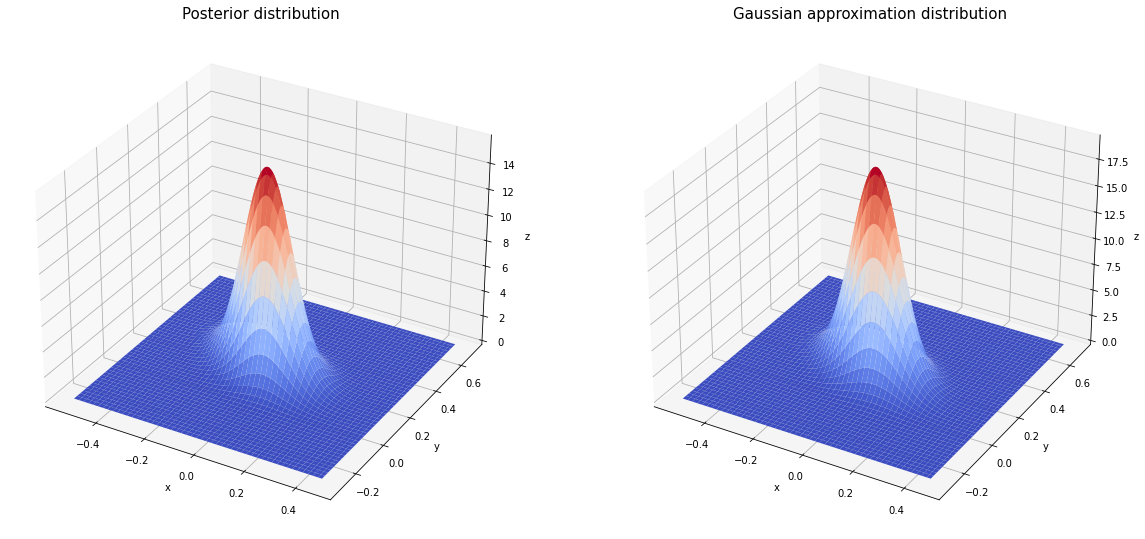

tensor([[ 0.3802, -2.5218, -1.9968, -0.7591, -1.6118, -2.3552, -3.4952, -3.3852,
         -0.3096,  1.5253,  1.2866,  2.3397,  0.6057,  0.3633, -0.5687,  0.0075,
          0.6049,  0.7464, -0.0297, -1.6295,  0.0686,  0.3543, -0.5030, -0.9892,
          2.2229],
        [ 1.7489, -0.6676, -3.1691,  1.8181,  1.1957, -2.0338, -1.9146, -3.5323,
          0.6922, -0.8435,  4.6912, -0.8633, -1.0912, -0.3115, -0.6366, -0.7164,
          1.8487,  0.2138,  0.9437,  0.6746,  0.7381, -1.1495,  0.3074,  1.1615,
          2.8570],
        [-0.3402,  2.9526,  1.4177,  4.2110,  2.5488,  4.0497,  3.2585,  3.8504,
          2.0479,  1.2870, -1.7647, -4.1368,  0.5146, -1.0420, -1.7126, -0.2157,
          0.0241, -0.4853,  0.8545,  0.4232,  0.0773, -1.9959,  0.2468, -1.1171,
         -2.7282]])

In [112]:
true_imps = gaussian_IMPS(1,1,q, true_phi_posterior11, normalization = False, prior_Sigma = None ,sampler = 'gaussian', freedom = 50)
true_imps.run(10,100,auto_target= False ) 
true_imps.plot_2D(nb_points = 300, interval_length = 0.5)

In [113]:
true_imps.guess

tensor(0.8363, grad_fn=<MeanBackward0>)

In [114]:
true_imps.true_value

0.8207692870219906

In [162]:
lam = 15
k = torch.tensor([lam - 0*math.sqrt(lam)])

def log_poiss(lam,k): 
    return -log_stirling(k)- lam + k*math.log(lam)

res = 1 
for i in range(250): 
    res*=torch.exp(log_poiss(lam,k))
    
print('res : ', res)
torch.exp(log_poiss(lam,k)

res :  tensor([1.6448e-247])


tensor([0.1030])

## Posterior distribution 

## $\phi_1$

TRUE VALUE :   0.6958267566430122
AN-IMPS mean  tensor(0.8327)
AN-IMPS var = 4.609586E-02
simple IMPS mean : tensor(0.6775)
simple IMPS var  = 1.424840E-03


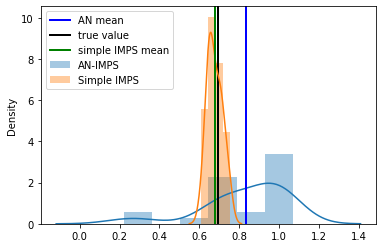

In [276]:
plot_bootstrap(1, 1,true_phi_posterior11)

TRUE VALUE :   139.03646571267294
AN-IMPS mean  tensor(138.9699)
AN-IMPS var = 1.725862E+00
simple IMPS mean : tensor(139.4027)
simple IMPS var  = 3.102729E+00


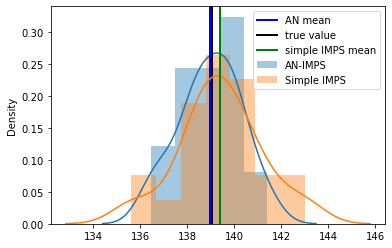

In [277]:
plot_bootstrap(2, 1,true_phi_posterior21)

TRUE VALUE :   0.21926806535700036
AN-IMPS mean  tensor(0.3239)
AN-IMPS var = 1.818293E-02
simple IMPS mean : tensor(0.2169)
simple IMPS var  = 4.513450E-04


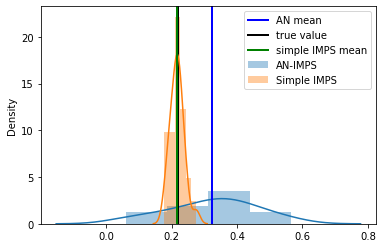

In [278]:
plot_bootstrap(3, 1,true_phi_posterior31)

## $\phi_2$

TRUE VALUE :   0.19845429000921688
AN-IMPS mean  tensor(0.2634)
AN-IMPS var = 1.452831E-02
simple IMPS mean : tensor(0.2534)
simple IMPS var  = 1.004235E-01


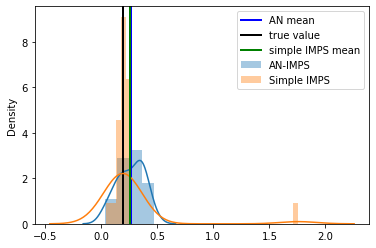

In [279]:
plot_bootstrap(1, 2,true_phi_posterior12)

TRUE VALUE :   -1.051817105240144e-185
AN-IMPS mean  tensor(-166.3268)
AN-IMPS var = 7.402343E+00
simple IMPS mean : tensor(-166.7212)
simple IMPS var  = 4.210224E+00


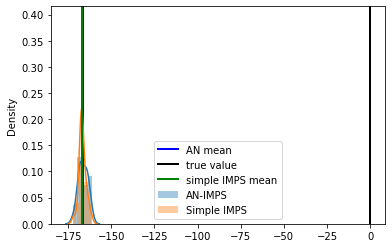

In [280]:
plot_bootstrap(2, 2,true_phi_posterior22)

TRUE VALUE :   -0.02016083857698283
AN-IMPS mean  tensor(-0.0287)
AN-IMPS var = 9.060173E-04
simple IMPS mean : tensor(-0.0204)
simple IMPS var  = 3.432526E-04


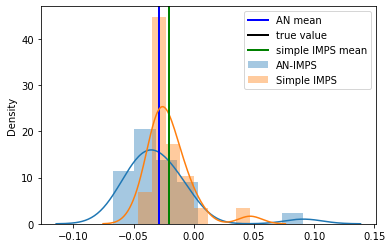

In [281]:
plot_bootstrap(3, 2,true_phi_posterior32)

## $\phi_3$

TRUE VALUE :   0.26280260109463793
AN-IMPS mean  tensor(0.2251)
AN-IMPS var = 2.791688E-02
simple IMPS mean : tensor(0.2319)
simple IMPS var  = 1.911471E-02


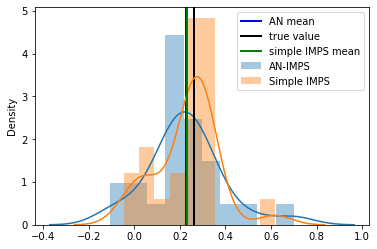

In [45]:
plot_bootstrap(1, 3,true_phi_posterior13)

TRUE VALUE :   -0.008935068809273618
AN-IMPS mean  tensor(-1.1989)
AN-IMPS var = 2.990783E-04
simple IMPS mean : tensor(-1.1983)
simple IMPS var  = 1.445118E-04


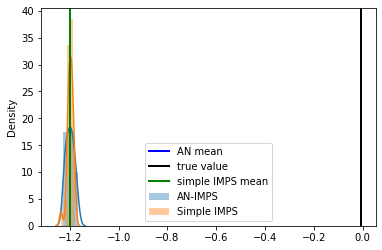

In [46]:
plot_bootstrap(2, 3,true_phi_posterior23)

TRUE VALUE :   -0.14129748260200678
AN-IMPS mean  tensor(-0.1177)
AN-IMPS var = 7.944295E-03
simple IMPS mean : tensor(-0.1532)
simple IMPS var  = 3.906545E-03


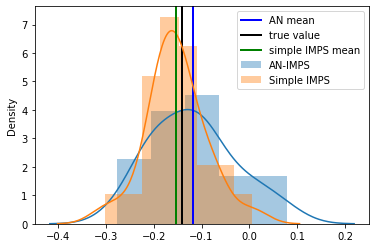

In [47]:
plot_bootstrap(3, 3,true_phi_posterior33)

# normalization constant estimation 

Note that this works only with classic IMPS. 

## first sample : 


TRUE VALUE :   0.7652951194335235
AN-IMPS mean  tensor(nan)
AN-IMPS var = NAN
simple IMPS mean : tensor(0.7688)
simple IMPS var  = 1.662035E-02


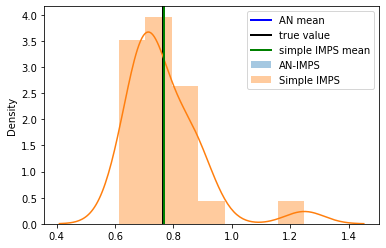

In [48]:
plot_bootstrap(1, 4,constant1)

TRUE VALUE :   0.7652951194335235
AN-IMPS mean  tensor(nan)
AN-IMPS var = NAN
simple IMPS mean : tensor(0.7246)
simple IMPS var  = 1.120868E-02


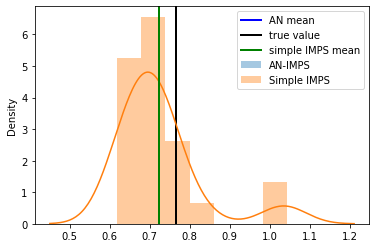

In [49]:
plot_bootstrap(1, 4,constant1)

# Second sample

TRUE VALUE :   0.011198828835154087
AN-IMPS mean  tensor(nan)
AN-IMPS var = NAN
simple IMPS mean : tensor(0.0112)
simple IMPS var  = 3.291684E-08


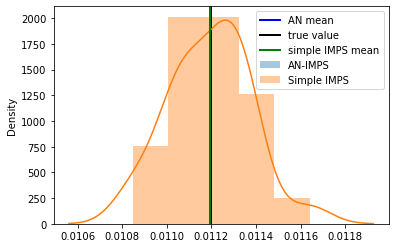

In [50]:
plot_bootstrap(2, 4,constant2)

TRUE VALUE :   0.011198828835154087
AN-IMPS mean  tensor(nan)
AN-IMPS var = NAN
simple IMPS mean : tensor(0.0112)
simple IMPS var  = 1.792959E-08


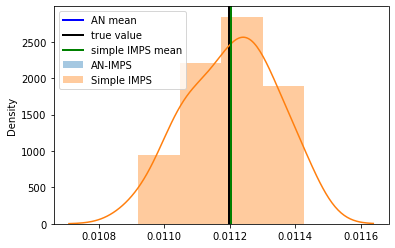

In [51]:
plot_bootstrap(2, 4,constant2)

# Third sample 

TRUE VALUE :   0.7323891068515652
AN-IMPS mean  tensor(nan)
AN-IMPS var = NAN
simple IMPS mean : tensor(0.7850)
simple IMPS var  = 1.292383E-02


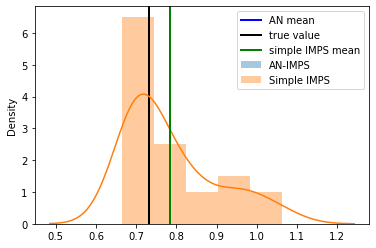

In [52]:
plot_bootstrap(1, 4,constant3)

TRUE VALUE :   0.7323891068515652
AN-IMPS mean  tensor(nan)
AN-IMPS var = NAN
simple IMPS mean : tensor(0.0112)
simple IMPS var  = 1.672464E-08


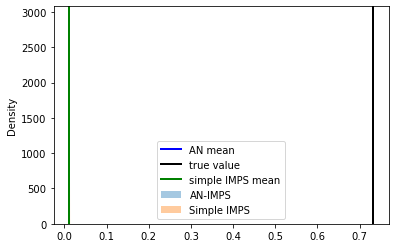

In [53]:
plot_bootstrap(2, 4,constant3)

# Next test 

$\phi_1$

TRUE VALUE :   0.6958267566430121
AN-IMPS mean  tensor(0.8645)
AN-IMPS var = 3.077468E-02
simple IMPS mean : tensor(0.6934)
simple IMPS var  = 4.973987E-03


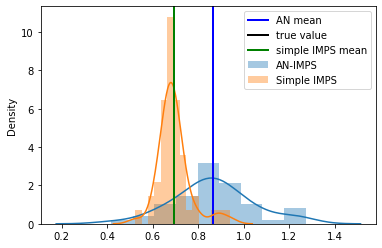

In [113]:
plot_bootstrap(1, 1,true_phi_posterior11)

TRUE VALUE :   139.03646571267427
AN-IMPS mean  tensor(138.4342)
AN-IMPS var = 2.586526E+00
simple IMPS mean : tensor(138.9636)
simple IMPS var  = 3.806130E+00


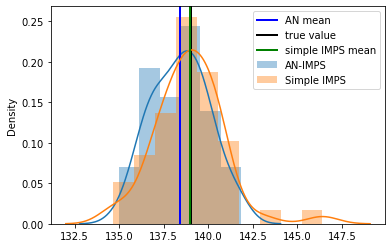

In [114]:
plot_bootstrap(2, 1,true_phi_posterior21)

TRUE VALUE :   0.2192680653570004
AN-IMPS mean  tensor(0.3493)
AN-IMPS var = 1.585571E-02
simple IMPS mean : tensor(0.2156)
simple IMPS var  = 4.404385E-04


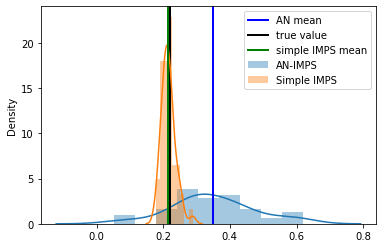

In [115]:
plot_bootstrap(3, 1,true_phi_posterior31)



## $\phi_2$

TRUE VALUE :   0.19845429000921694
AN-IMPS mean  tensor(0.2365)
AN-IMPS var = 1.342839E-02
simple IMPS mean : tensor(0.1754)
simple IMPS var  = 3.753790E-03


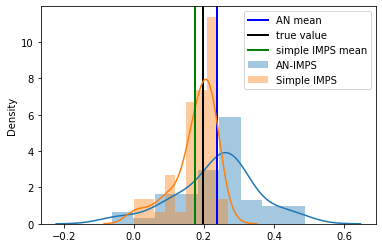

In [116]:


plot_bootstrap(1, 2,true_phi_posterior12)



TRUE VALUE :   -1.0518171052401439e-185
AN-IMPS mean  tensor(-166.1921)
AN-IMPS var = 7.901719E+00
simple IMPS mean : tensor(-166.6440)
simple IMPS var  = 4.324799E+00


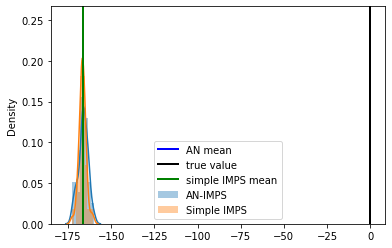

In [117]:
plot_bootstrap(2, 2,true_phi_posterior22)



TRUE VALUE :   -0.020160838576982833
AN-IMPS mean  tensor(-0.0350)
AN-IMPS var = 5.081878E-04
simple IMPS mean : tensor(-0.0245)
simple IMPS var  = 3.630731E-04


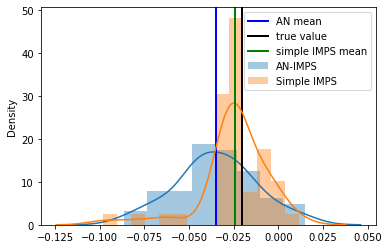

In [118]:
plot_bootstrap(3, 2,true_phi_posterior32)

## $\phi_3$


 ## $\phi_3$

TRUE VALUE :   0.2628026010946379
AN-IMPS mean  tensor(0.2608)
AN-IMPS var = 1.108005E-02
simple IMPS mean : tensor(0.2495)
simple IMPS var  = 2.110138E-02


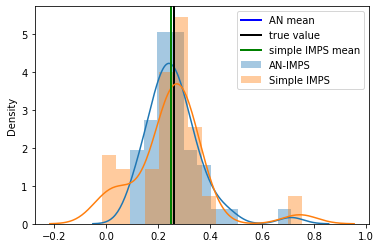

In [119]:

plot_bootstrap(1, 3,true_phi_posterior13)



TRUE VALUE :   -0.008935068809273543
AN-IMPS mean  tensor(-1.2013)
AN-IMPS var = 2.330019E-04
simple IMPS mean : tensor(-1.1963)
simple IMPS var  = 2.179115E-04


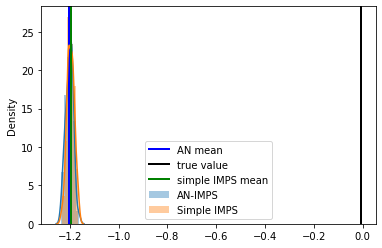

In [120]:
plot_bootstrap(2, 3,true_phi_posterior23)

TRUE VALUE :   -0.14129748260200686
AN-IMPS mean  tensor(-0.1674)
AN-IMPS var = 7.548939E-03
simple IMPS mean : tensor(-0.1273)
simple IMPS var  = 3.752016E-03


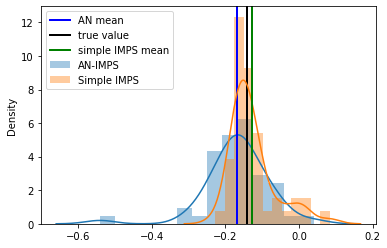

In [121]:
plot_bootstrap(3, 3,true_phi_posterior33)

TRUE VALUE :   1
AN-IMPS mean  tensor(1.)
simple IMPS mean : tensor(0.0112)
AN-IMPS var = 1.458990E-32
simple IMPS var  = 2.594989E-08


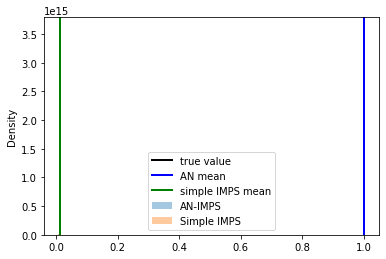

In [569]:
plot_bootstrap(2, 4,constant2)

In [570]:
constant2 = 0.0112

In [117]:
def sample_gaussians(N_samples, sqrt_Sigma, mean):
    '''
    samples some gaussians with the right mean and variance. Be careful, we ask 
    for the square root of Sigma, not Sigma. 
    '''
    q = mean.shape[0]
    W = torch.matmul(sqrt_Sigma.unsqueeze(0), torch.randn(N_samples,q).unsqueeze(2)).squeeze() + mean.unsqueeze(0)
    return W

In [229]:
class IMPS_constant():
    def __init__(self, Y_i,covariates_i, O_i,C,beta, sampler = 'gaussian', freedom = 5): 
        self.Y_i = Y_i
        self.covariates_i = covariates_i
        self.O_i = O_i
        self.C = C 
        self.beta = beta
        self.freedom = freedom 
        self.sampler = sampler
        def un_log_posterior(W): 
            return log_P_WgivenY(self.Y_i, self.covariates_i, self.O_i , W, self.C, self.beta)
        self.un_log_posterior = un_log_posterior 
        self.q = self.C.shape[1]
    def find_mode(self, N_iter,lr): 
        W = torch.zeros(self.q)
        W.requires_grad_(True)
        optimizer = torch.optim.Rprop([W], lr = lr)
        for i in range(N_iter) : 
            gain = -self.un_log_posterior(W)
            gain.backward()
            optimizer.step()
            optimizer.zero_grad()
        self.mode = torch.clone(W)
        print('mode :', self.mode)
        # del(W) ??
        
    def scale_un_log_posterior(self): # sert a qqch ?  
        self.missed_log_constant = self.un_log_posterior(self.mode)
        def new_log_posterior(W): 
            return self.un_log_posterior(W) - self.missed_log_constant
        self.scaled_log_posterior = new_log_posterior
    def get_best_var(self):
        '''
        get the best var, i.e. the inverse of the hessian of the log of the integrand. 
        '''
        batch_matrix = torch.matmul(self.C.unsqueeze(2), self.C.unsqueeze(1))
        #print('batch_mat ', batch_matrix)
        common = torch.exp(self.O_i + (self.mode.reshape(1,-1)@(self.C.T)).squeeze() +self.covariates_i@self.beta).unsqueeze(1).unsqueeze(2)
        prod = batch_matrix*common
        Hess_post = torch.sum(prod, axis = 0)+ torch.eye(self.q) 
        #print('before inv ', Hess_post)
        self.Sigma = torch.inverse(Hess_post.detach())
        #print('Sigma :', self.Sigma)
        print('det sigma ', torch.det(self.Sigma))
        self.sqrt_Sigma = torch.from_numpy(SLA.sqrtm(self.Sigma))
    
    def get_weights(self,W):
        '''
        get the weights for the importance sampling. This function does not normalize the weights. 
        '''
        self.log_f = self.scaled_log_posterior(W)
        if self.sampler == 'gaussian':
            self.log_g = gaussian_log_density(W, self.mode, self.Sigma)
        elif self.sampler == 'student' : 
            self.log_g = log_student_density(W, self.mode, self.Sigma,  self.freedom)
        return torch.exp(self.log_f-self.log_g)
        
        
    def run(self, N_iter, lr, N_s):
        self.find_mode(N_iter,lr)
        self.scale_un_log_posterior()
        self.get_best_var()
        if self.sampler == 'gaussian' : 
            samples = sample_gaussians(N_s, self.sqrt_Sigma, self.mode)
        elif self.sampler == 'student' : 
            samples = sample_student(N_s,self.mode,self.Sigma,self.freedom)
        
        weights = self.get_weights(samples)
        return torch.mean(weights)#*torch.exp(self.missed_log_constant)
        
    

In [282]:
#bad ones 
d = 2
n = 3;  p = 40
q = 10
m,l = 0,0

In [283]:
# 10 est pas mal 
torch.manual_seed(3)
Sigma_sampling = 1*torch.from_numpy(build_block_Sigma(p,4))*2 #+ 0.5*torch.eye(p)
true_C = torch.from_numpy(C_from_Sigma(Sigma_sampling, q))
true_Sigma_sampling = true_C@(true_C.T)
true_beta =torch.randn((d, p))/1

covariates = torch.randn((n,d))/1
O =  0+torch.zeros((n,p))
sample_model = sample_PLN()
Y, Z  = sample_model.sample(Sigma_sampling,true_beta, O, covariates)
Y = torch.from_numpy(Y)
Y

tensor([[   0,    2,    1,    0,    1,    0,    0,    5,    3,    1,    0,    0,
            1,    1,    7,    3,    0,    0,    0,    0,    2,    0,    2,    1,
            1,    2,   10,    0,    0,    0,    2,    0,    4,   48,    0,    0,
            0,    0,    0,    0],
        [   0,    0,    0,    5,    0,    0,    1,   24,   14,    1,    1,    9,
            0,    0,    0,    0,    0,    0,    0,    3,   21,    1,   51,    0,
            1,    0,    0,    0,   52,   44,   98,    2,    1,    0,    2,    0,
            4,    5,    0,    3],
        [   1,    0,    4,   11,   12,    4, 1898,  907,   23,    0,    2,    3,
            1,    0,    0,    0,    0,    1,    1,    1,    1,    0,    0,    0,
            0,    0,    0,    0,    0,    1,    1,    4,    5,   32,    1,    3,
            1,    2,    7,    0]])

In [293]:
i = 0
test = IMPS_constant(Y[i], covariates[i], O[i] , true_C, true_beta)
test.run(1000, 0.5, 100)

mode : tensor([ 2.4545,  0.0161,  0.3489, -0.2681, -0.9224,  0.3843,  0.4419,  1.1993,
        -0.0091, -0.6440], grad_fn=<CloneBackward>)
det sigma  tensor(6.2744e-14)


tensor(0.0028, grad_fn=<MeanBackward0>)

In [201]:
i = 1
test = IMPS_constant(Y[i], covariates[i], O[i] , true_C, true_beta)
test.run(100, 0.5, 100)

det sigma  tensor(3.2243e-19)


tensor(5.9099e-06, grad_fn=<MeanBackward0>)

In [241]:
i = 2
test = IMPS_constant(Y[i], covariates[i], O[i] , true_C, true_beta)
test.run(400, 0.5, 1000)

mode : tensor([ 0.9544,  0.0310, -4.0368,  0.9772, -0.0521, -3.2941,  5.1157,  0.1873,
         0.9290,  0.5440], grad_fn=<CloneBackward>)
det sigma  tensor(2.3524e-19)


tensor(3.9317, grad_fn=<MeanBackward0>)

In [316]:
torch.exp(test.scaled_log_posterior(test.mode)+test.missed_log_constant)

tensor(3.2811e-194, grad_fn=<ExpBackward>)

In [263]:
i = 2
test = IMPS_constant(Y[i], covariates[i], O[i] , true_C, true_beta)
test.run(1000, 0.5, 1000)

mode : tensor([ 9.3513e-01,  3.0540e-03, -4.7717e+00,  8.5765e-01, -1.7944e-02,
        -4.1883e+00,  5.8255e+00,  1.8177e-01,  1.6492e+00,  5.2766e-01],
       grad_fn=<CloneBackward>)
det sigma  tensor(9.0479e-19)


tensor(2.4418e-05, grad_fn=<MeanBackward0>)

In [300]:
mean = torch.zeros(2)
cov = torch.ones(2,2)
print(cov)
print(torch.distributions.MultivariateNormal(mean,cov))

tensor([[1., 1.],
        [1., 1.]])


ValueError: The parameter covariance_matrix has invalid values